# COVID-19 country growth analysis


Compares the growth rate of COVID-19 infections within countries.

Important to note:

 - Countries often see a high growth rate in the initial 2-3 weeks due to travellers returning from overseas who (at least in Australia) tend to make up the majority of cases
 - Community transmission is low early and takes hold after this initial 2-3 week period. Countries that are able to slow the community transmission early (by controlling returned travellers through quarantine etc.) have proved most effective in controlling the infection rate
 - It is commonly accepted that infection rates are higher than those reported due to: 
 
  a) lack of availability of testing kits; 
  
  b) strict criteria on who is able to receive a test (due to lack of availability of kits);
  
  c) asymptomatic carriers of the virus (some predictions are around 20%)

In [1]:
# wrangling tools
import numpy as np
import pandas as pd
import datetime as dt
# viz tools
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [3]:
#import sys
#!{sys.executable} -m pip install plotnine

In [2]:
df_c19_all = pd.read_csv('covid_19_data.csv')
df_c19_all.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [3]:
# initial cleaning

df_c19_all['ObservationDate'] = pd.to_datetime(df_c19_all['ObservationDate'])
df_c19_all.rename(columns={'Country/Region':'Country'}, inplace=True)

This data provides granularity down to the province level, which is useful when looking at countries like China and US. For now though, we are interested in the total confirmed cases per day per country, so we aggregate.

In [80]:
def latest_over_thresh(df, num_inf):
    
    '''
    Returns a df with the data for all countries that, as of the latest date in the data,
    have over a certain amount of infections (num_inf)
    '''
    
    latest_date = latest_date = str(dt.date.today() - dt.timedelta(days=2))
    
    df_latest = df[df['ObservationDate'] == latest_date]
    
    country_list = list(df_latest[df_latest['Confirmed'] >= num_inf].Country)
    df_over_thresh = df[df['Country'].isin(country_list)]
    df_over_thresh = df_over_thresh[['ObservationDate','Country','Confirmed','Deaths', 'Recovered']].groupby(['Country', 'ObservationDate']).sum()
    #df_over_thresh.sort_values('Confirmed', ascending=False, inplace=True)
    df_over_thresh.reset_index(inplace=True)
    
    return(df_over_thresh)

In [144]:
def days_since_100_cases(df):
    
    '''Take the latest df, filter for days where country has over
    100 cases, then make new field with count since 100 cases'''
    
    
    df_largest_infRates = latest_over_thresh(df_c19_all, 1000)
    df_largest_infRates.sort_values(['Country','ObservationDate'], inplace=True)

    df_100 = df_largest_infRates[df_largest_infRates['Confirmed'] >= 100]
    df_100['Days_since_100'] = df_over_100.groupby('Country').cumcount()
    
    return(df_100)

In [146]:
df_over_100 = days_since_100_cases(df_c19_all)
df_over_100[df_over_100['Country'] == "Mainland China"]


/Users/mitchellstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Country,ObservationDate,Confirmed,Deaths,Recovered,Days_since_100
865,Mainland China,2020-01-22,547.0,17.0,28.0,0
866,Mainland China,2020-01-23,639.0,18.0,30.0,1
867,Mainland China,2020-01-24,916.0,26.0,36.0,2
868,Mainland China,2020-01-25,1399.0,42.0,39.0,3
869,Mainland China,2020-01-26,2062.0,56.0,49.0,4
...,...,...,...,...,...,...
927,Mainland China,2020-03-24,81180.0,3277.0,73169.0,62
928,Mainland China,2020-03-25,81221.0,3281.0,73661.0,63
929,Mainland China,2020-03-26,81298.0,3287.0,74061.0,64
930,Mainland China,2020-03-27,81345.0,3292.0,74600.0,65


Plot countries' infection growth (where countries currently have over 1000 confirmed cases) from 100 cases onwards

In [547]:
def growth_comparison_lineplot(df, plot_title, label_cond):
    
    p1 = (p9.ggplot(df, p9.aes('Days_since_100', 'Confirmed'))
     + p9.geoms.geom_line(p9.aes(colour='Country'))
     + p9.geoms.geom_text(mapping=p9.aes(label='Country'),
                          data = label_cond,
                         size=7, nudge_x=0)
     + p9.scales.scale_colour_discrete(guide=False)
     + p9.themes.theme_bw()
     + p9.theme(figure_size=(7,5))
     + p9.labels.labs(title = plot_title,
                     x = "Days since 100 cases",
                     y = 'Number of cases')
    )

    return(p1)

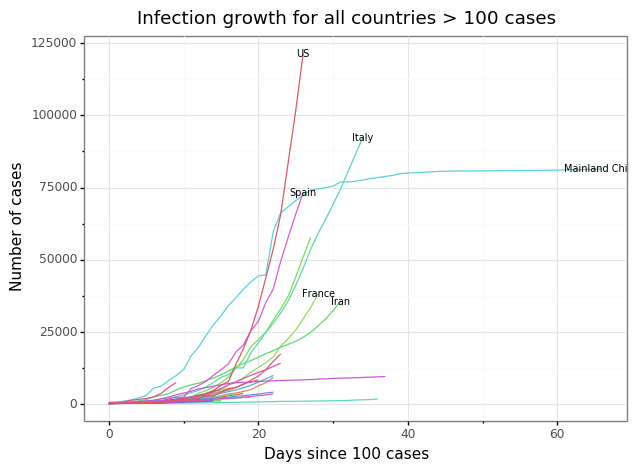

<ggplot: (7561975557)>

In [548]:
line_labels = df_over_100[(df_over_100['ObservationDate']=='2020-03-28') & 
            (df_over_100['Country'].isin(['US', 'Mainland China', 'Italy',
                                'France', 'Spain', 'Iran']))]

growth_comparison_lineplot(df_over_100, 
                           "Infection growth for all countries > 100 cases",
                          line_labels)

Plot countries who's latest infection number is greater than 10,000

In [549]:
def plot_country_bracket(df, lower_lmt, upper_lmt, title):
    
    df_between = df.groupby('Country').max()
    
    if (lower_lmt > 0 and upper_lmt == 0):
        df_between = df_between[df_between['Confirmed'] >= lower_lmt]
    elif (upper_lmt > 0 and lower_lmt == 0):
        df_between = df_between[df_between['Confirmed'] <= upper_lmt]
    else:
        df_between = df_between[(df_between['Confirmed'] >= lower_lmt) & (df_between['Confirmed'] <= upper_lmt)]    
    
    country_list = list(df_between.index)
    
    df_filtered = df[df['Country'].isin(country_list)]
    
    latest_date = latest_date = str(dt.date.today() - dt.timedelta(days=2))
    line_labels = df_filtered[df_filtered['ObservationDate'] == latest_date]
    growth_plot = growth_comparison_lineplot(df_filtered, 
                                             title,
                                            line_labels)
    
    return(growth_plot)

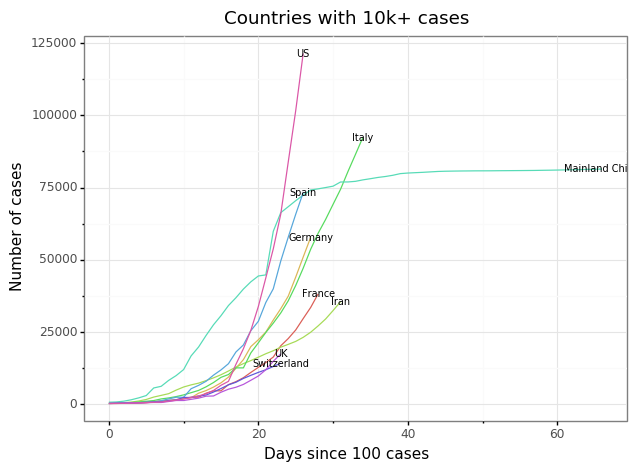

<ggplot: (7562706181)>

In [550]:
plot_country_bracket(df_over_100, 10000, 0, "Countries with 10k+ cases")

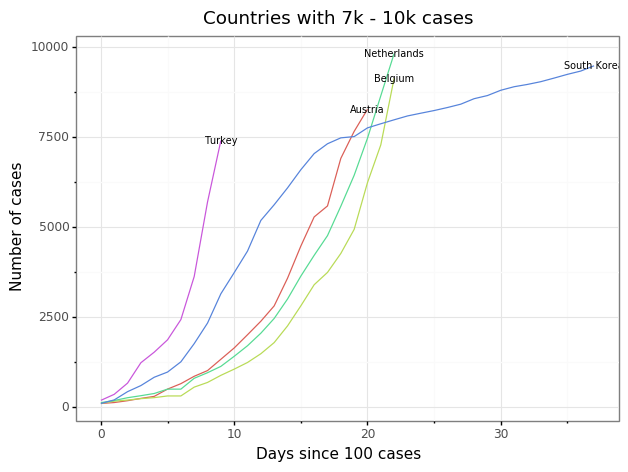

<ggplot: (7564209609)>

In [551]:
plot_country_bracket(df_over_100, 7000, 10000, "Countries with 7k - 10k cases")

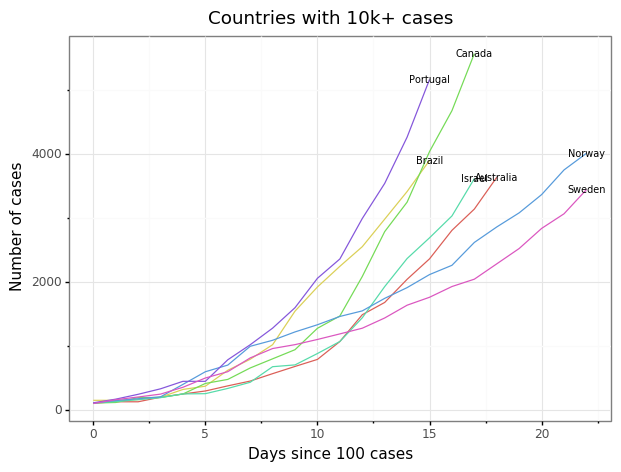

<ggplot: (7560183753)>

In [552]:
plot_country_bracket(df_over_100, 3000, 7000, "Countries with 10k+ cases")

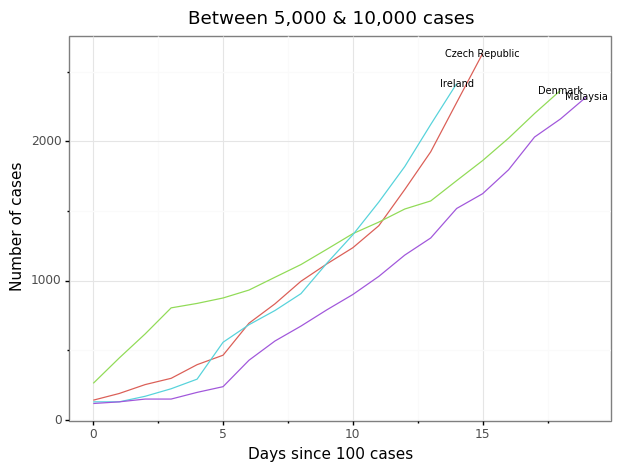

<ggplot: (7561706837)>

In [554]:
plot_country_bracket(df_over_100, 2000, 3000, "Between 5,000 & 10,000 cases")

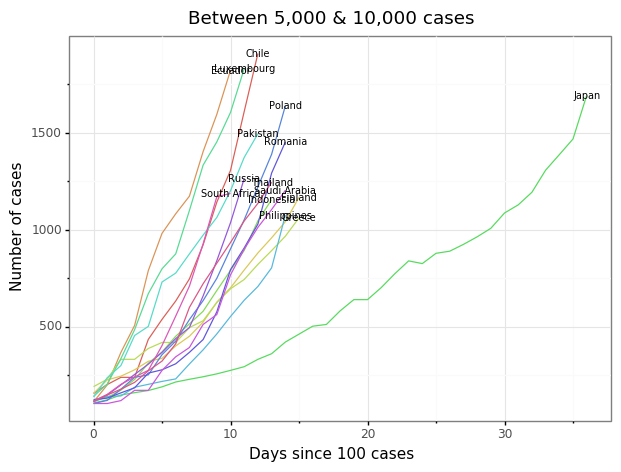

<ggplot: (7559593525)>

In [555]:
plot_country_bracket(df_over_100, 1000, 2000, "Between 5,000 & 10,000 cases")

In [19]:
def pivot_pct_change(df):
    
    df_pivot = df.pivot('ObservationDate', 'Country', 'Confirmed').reset_index()
    df_pivot = df_pivot.fillna(0)
    
    df_pivot[['aus_pct_change', 'tw_pct_change']] = df_pivot[['Australia', 'Taiwan']].pct_change()
    df_pivot.fillna(0, inplace=True)
    
    
    df_melted = df_pivot[['ObservationDate', 'aus_pct_change', 'tw_pct_change']].melt('ObservationDate',
                                                                                      var_name='Country',
                                                                                      value_name='pct_change').sort_values(['ObservationDate', 'Country'])
    countries = {'aus_pct_change':'Australia',
               'tw_pct_change': 'Taiwan'}
    df_melted['Country'] = df_melted['Country'].map(countries)
    df_melted.reset_index(inplace = True, drop=True)
    
    return(df_melted)

In [20]:
au_tw_pctchange = pivot_pct_change(df_au_tw)
au_tw_pctchange

,ObservationDate,Country,pct_change
0,2020-01-22,Australia,0.000000
1,2020-01-22,Taiwan,0.000000
2,2020-01-23,Australia,0.000000
3,2020-01-23,Taiwan,0.000000
4,2020-01-24,Australia,0.000000
...,...,...,...
129,2020-03-26,Taiwan,0.072340
130,2020-03-27,Australia,0.118505
131,2020-03-27,Taiwan,0.059524
132,2020-03-28,Australia,0.158129


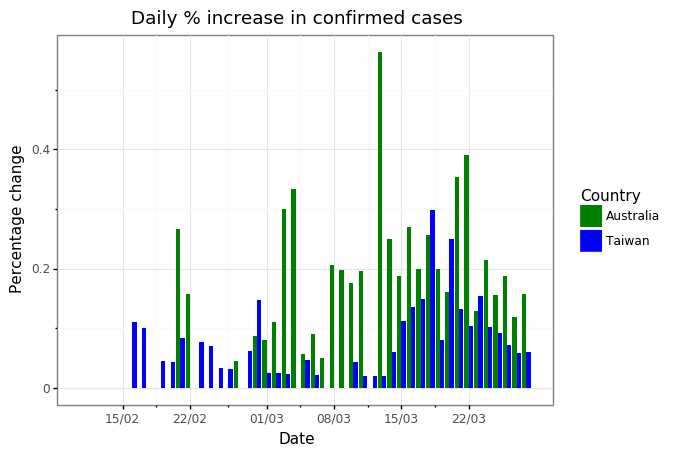

<ggplot: (7551131621)>

In [21]:
(p9.ggplot(au_tw_pctchange[au_tw_pctchange['ObservationDate'] > '2020-02-10'], 
           p9.aes('ObservationDate', 'pct_change', 
                      fill='Country'))
 + p9.geoms.geom_col(stat='identity', position='dodge')
 + p9.scales.scale_fill_manual(values = ("green", "blue"))
 + p9.themes.theme_bw()
 + p9.scales.scale_x_date(labels = date_format('%d/%m'))
 + p9.labels.labs(title = "Daily % increase in confirmed cases",
                 y = "Percentage change",
                 x = "Date")
)

It is clear from the above that Australia has had a much higher daily percentage increase in confirmed cases since mid February.

At what point did first deaths occur?

In [317]:
def print_first_date(df, country, metric):
   
    country_df = df[df['Country'] == country]
    
    var = country_df[country_df[metric] >= 1.0].sort_values('ObservationDate').head(1)['ObservationDate']
    var = np.datetime_as_string(var.values[0])[:10]
    
    print(var)

In [318]:
countries = ['Australia', 'Taiwan']
metric = ['Confirmed', 'Deaths']

for c in countries:
    for m in metric:
        print('The first {} '.format(m)+ 'in {} occurred on:'.format(c)) 
        print_first_date(df_au_tw, c, m)

The first Confirmed in Australia occurred on:
2020-01-25
The first Deaths in Australia occurred on:
2020-03-01
The first Confirmed in Taiwan occurred on:
2020-01-22
The first Deaths in Taiwan occurred on:
2020-02-16


In [319]:
df_c19_all[df_c19_all['Country'] == "Taiwan"]

,SNo,ObservationDate,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
28,29,2020-01-22,Taiwan,Taiwan,1/22/2020 17:00,1.0,0.0,0.0
66,67,2020-01-23,Taiwan,Taiwan,1/23/20 17:00,1.0,0.0,0.0
107,108,2020-01-24,Taiwan,Taiwan,1/24/20 17:00,3.0,0.0,0.0
154,155,2020-01-25,Taiwan,Taiwan,1/25/20 17:00,3.0,0.0,0.0
199,200,2020-01-26,Taiwan,Taiwan,1/26/20 16:00,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...
7118,7119,2020-03-20,NaN,Taiwan,2020-03-20T09:43:03,135.0,2.0,26.0
7421,7422,2020-03-21,NaN,Taiwan,2020-03-21T07:43:02,153.0,2.0,28.0
7761,7762,2020-03-22,NaN,Taiwan,3/8/20 5:31,169.0,2.0,28.0
8059,8060,2020-03-23,NaN,Taiwan,2020-03-23 23:23:20,195.0,2.0,28.0


In [320]:
df_cov19_detail = pd.read_csv('COVID19_open_line_list.csv')
df_cov19_detail.dropna(axis='columns', how='all', inplace=True)
df_cov19_detail.dropna(how='all', inplace=True)
df_cov19_detail

,ID,age,sex,city,province,country,wuhan(0)_not_wuhan(1),latitude,longitude,geo_resolution,...,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials
0,1.0,30,male,"Chaohu City, Hefei City",Anhui,China,1.0,31.646960,117.716600,admin3,...,NaN,NaN,NaN,NaN,Chaohu City,Hefei City,Anhui,China,340181,NaN
1,2.0,47,male,"Baohe District, Hefei City",Anhui,China,1.0,31.778630,117.331900,admin3,...,NaN,NaN,NaN,NaN,Baohe District,Hefei City,Anhui,China,340111,NaN
2,3.0,49,male,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui,China,340104,NaN
3,4.0,47,female,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui,China,340104,NaN
4,5.0,50,female,"Feidong County, Hefei City",Anhui,China,1.0,32.001230,117.568100,admin3,...,NaN,NaN,NaN,NaN,Feidong County,Hefei City,Anhui,China,340122,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13169,13475.0,60-69,male,Nagoya City,Aichi Prefecture,Japan,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13170,13476.0,40-49,female,NaN,Osaka,Japan,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13171,13477.0,0-10,female,NaN,Osaka,Japan,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13172,13478.0,NaN,female,Amsterdam,NaN,Netherlands,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [298]:
df_cov19_detail[df_cov19_detail['country'] == "Australia"].columns

Index(['ID', 'age', 'sex', 'city', 'province', 'country',
       'wuhan(0)_not_wuhan(1)', 'latitude', 'longitude', 'geo_resolution',
       'date_onset_symptoms', 'date_admission_hospital', 'date_confirmation',
       'symptoms', 'lives_in_Wuhan', 'travel_history_dates',
       'travel_history_location', 'reported_market_exposure',
       'additional_information', 'chronic_disease_binary', 'chronic_disease',
       'source', 'sequence_available', 'outcome', 'date_death_or_discharge',
       'notes_for_discussion', 'location', 'admin3', 'admin2', 'admin1',
       'country_new', 'admin_id', 'data_moderator_initials'],
      dtype='object')

In [305]:
# what are the most common symptoms?

symptoms = df_cov19_detail['symptoms'].dropna()
print(symptoms.value_counts())

fever                                    131
cough, fever                              55
pneumonitis                               19
cough                                     15
pneumonia                                  7
                                        ... 
systemic weakness, runny nose, fever       1
fever; runny nose                          1
Fever (37.4 ° C), malaise, sore throa      1
cough; fever                               1
discomfort, fever                          1
Name: symptoms, Length: 217, dtype: int64
